In [3]:
from __future__ import print_function, division

from glob import glob
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import shutil
from torchvision import models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchvision.datasets as datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [4]:
path = '/Users/taehoonkim/Desktop/kickandkicktest'

files = glob(os.path.join(path,'*/*.jpg'))

print(f'Total no of images {len(files)}')

no_of_images = len(files)

shuffle = np.random.permutation(no_of_images)

for t in ['train', 'val']:
    os.mkdir(os.path.join(path, t))

Total no of images 344


FileExistsError: [Errno 17] File exists: '/Users/taehoonkim/Desktop/kickandkicktest/train'

In [5]:
for t in ['train', 'val']:
    for folder in ['ehffu/','ehfro/']:
        os.mkdir(os.path.join(path,t,folder))

FileExistsError: [Errno 17] File exists: '/Users/taehoonkim/Desktop/kickandkicktest/train/ehffu/'

In [6]:
for t in ['train', 'val']:   
    for i in shuffle[:50]:
        folder = files[i].split('/')[-1].split('.')[0].split('_')[0]
        image = files[i].split('/')[-1]
        shutil.copy(files[i],os.path.join(path,t, folder, image))

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/Users/taehoonkim/Desktop/kickandkicktest'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

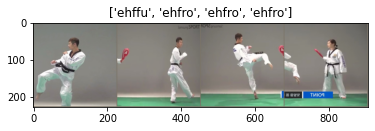

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/taehoonkim/miniforge3/envs/kim/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/taehoonkim/miniforge3/envs/kim/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5831 Acc: 0.7234
val Loss: 0.2546 Acc: 0.9787

Epoch 1/24
----------
train Loss: 0.3782 Acc: 0.8298
val Loss: 0.0297 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.3828 Acc: 0.8830
val Loss: 0.0018 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1403 Acc: 0.9681
val Loss: 0.1923 Acc: 0.9149

Epoch 4/24
----------
train Loss: 0.2776 Acc: 0.8617
val Loss: 0.0009 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.4619 Acc: 0.8298
val Loss: 0.1598 Acc: 0.9043

Epoch 6/24
----------
train Loss: 0.1447 Acc: 0.9362
val Loss: 0.0174 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0301 Acc: 0.9894
val Loss: 0.0005 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0575 Acc: 0.9787
val Loss: 0.0004 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0505 Acc: 0.9894
val Loss: 0.0004 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.4451 Acc: 0.8830
val Loss: 0.0004 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0713 Acc: 0.9894
val Loss: 0.0004 Acc: 1.0000

Ep